# Compression
References:
- https://pdfs.semanticscholar.org/f1b2/0a5681e6ef7080e5b5fbce81911c6873543c.pdf

What We plan to do is this:

![logDomainComp](img/logDomainComp.png)


In [98]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# Gain Computer
![gainComputer](img/gainCompute.png)

For simplicity, we will build one without a knee:


$    y_G = \left\{\begin{array}{lr}
        X_G,  & x_G \leq T \\
        T+(x_G-T)/R, & x_G > T
        \end{array}\right\}$


In [99]:
def gainCompute(xg, threshold, ratio):
    yg = np.zeros_like(xg)
    under = xg<=threshold
    over = xg>threshold
    yg[under] = xg[under]
    yg[over] = threshold + (xg[over]-threshold)/ratio
    return yg
    

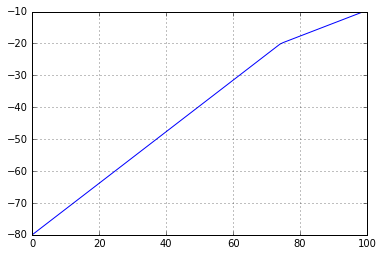

In [100]:
x = np.linspace(-80, 0, 100)
y = gainCompute(x,-20, 2)
plt.grid()
plt.plot(y)
plt.show()

### Faust implementation:
```
gainComputer(x,T,R) = ba.if((x<=T),x,comp) with {
  comp = T+(x-T)/R;
};
```

# Peak detector
("Branching Smooth Peak Detector")

$    y_L(n) = \left\{\begin{array}{lr}
        \alpha_A y_L(n-1)+(1-\alpha_A)x_L(n),  & \text{for } x_L(n)\gt y_L(n-1)\\
        \alpha_R y_L(n-1)+(1-\alpha_R)x_L(n),  & \text{for } x_L(n)\leq y_L(n-1)
        \end{array}\right\}$

To calculate the $\alpha$ pars (which are coefficients between 0 and 1) from actual time constants in seconds we can use:

$\alpha=e^{-1/(\tau f_s)}$
where $\tau$ is time in seconds, and $f_s$ is the sample rate.


In [36]:
def peakDetector(x,tA,tR,sr):
    
    aA = np.exp(-1/(tA*sr))
    aR = np.exp(-1/(tR*sr))
    
    N = len(x)
    y1 = 0
    Y = np.zeros_like(x)
    
    for n in range(N):
        if x[n]>y1:
            y1 = aA*y1+(1-aA)*x[n]
            Y[n] = y1
        else:
            y1 = aR*y1+(1-aR)*x[n]
            Y[n] = y1
    return Y            

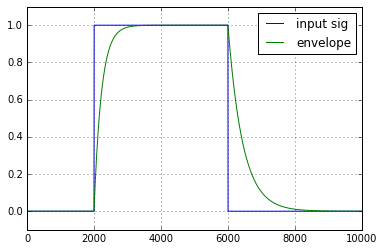

In [37]:
x = np.zeros(10000)
x[2000:6000]=1
env = peakDetector(np.abs(x), 0.005, 0.01,44100)
plt.plot(x, label='input sig')
plt.plot(env, label='envelope')
plt.grid()
plt.ylim([-0.1, 1.1])
plt.legend()
plt.show()

### Faust implementation(more or less):
```
peakDetector(x,att,rel) = lag_ud(att,rel,x);
```




## Combining both to get a compressor
We now just need to define lin ton dB and back funcktions and plug it all together
![logDomainComp](img/logDomainComp.png)


In [38]:
def dBToA(X):
    """Given a np.array calculates linear from dB values"""
    P1 = 10.**(X/20.)
    return P1
def aToDb(linArray, accuracy = 10):
    # A = 20*log10(V2/V1)\n    
    dbArray = 20.*np.log10(np.clip(linArray,10**-accuracy,10**accuracy))
    return dbArray


In [39]:
def compressor(x, thresh, ratio, makeup, attack, release, sr):
    dbVals = aToDb(np.abs(x))
    gainOut = gainCompute(dbVals,thresh,ratio)
    toPeakDetect = dbVals-gainOut
    toLin = makeup-peakDetector(toPeakDetect,attack,release,sr)
    sideChainOut = dBToA(toLin)
    y = x*sideChainOut
    return y,sideChainOut

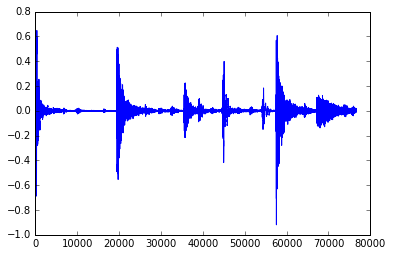

In [40]:
x,sr = librosa.load('drumLoop.wav')
plt.plot(x)
plt.show()

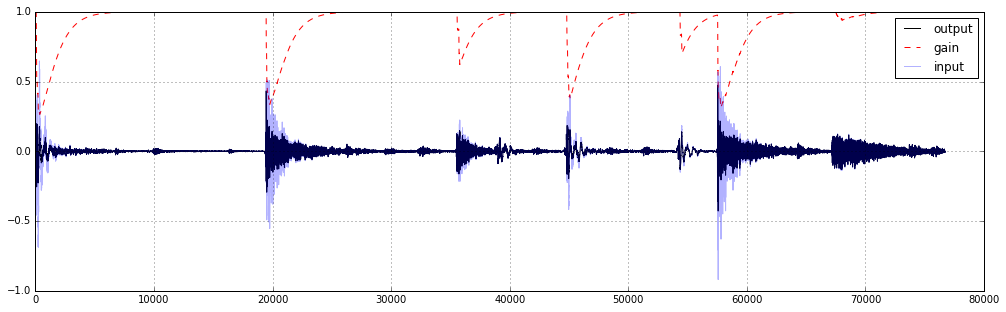

In [41]:
thresh = -20
ratio = 5
attack = 0.001
release = 0.05
makeup = 0
y,gainLin = compressor(x, thresh, ratio, makeup, attack, release, sr)

plt.figure(figsize=[17,5])
plt.plot(y,'k', label='output',)
plt.plot(gainLin,'r--', label='gain' )
plt.plot(x,'b', label='input', alpha=0.3)
plt.grid()
plt.legend(loc='best')
plt.show()